In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from scipy import sparse

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

In [2]:
df = pd.read_csv("diabetic_data.csv")
ids_mapping = pd.read_csv("IDS_mapping.csv")

Preprocessing

In [3]:
# Predict whether or not hospital patient will be readmitted within 30 days

# Replace "?" with NaN for simplicity
df = df.replace("?", np.nan)

# Target variable includes those recently readmitted (within 30 days)
# creates a binary target where 1 = readmitted <30, 0 otherise
if "readmitted" in df.columns:
    df["target"] = df["readmitted"].apply(lambda x: 1 if x == "<30" else 0)
    df = df.drop(["readmitted"], axis=1)
# Drop ID and unhelpful columns
drop_cols = [col for col in ids_mapping.columns if col in df.columns]
drop_cols += ["encounter_id", "patient_nbr"]
df = df.drop(columns=drop_cols, errors='ignore')

# Drop columns with excessive missing values or high cardinality
df = df.loc[:, df.isnull().mean() < 0.5]
df = df.drop(columns=[col for col in df.select_dtypes(include="object") if df[col].nunique() > 50])
df = df.dropna()

# One-hot encode with float dtype to avoid object dtype issues
df_dummies = pd.get_dummies(df, drop_first=True, dtype=float)

# Separate features and target
X = df_dummies.drop("target", axis=1)
y = df_dummies["target"]

# Convert to scipy sparse matrix
X_sparse = sparse.csr_matrix(X.values)

# Train/test split (sparse matrix version)
X_train_sparse, X_test_sparse, y_train, y_test = train_test_split(
    X_sparse, y, test_size=0.3, random_state=42
)

# Feature scaling using sparse-compatible scaler (no centering)
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train_sparse)
X_test_scaled = scaler.transform(X_test_sparse)

# Prepare to store metrics for later model evaluation
metrics = {}

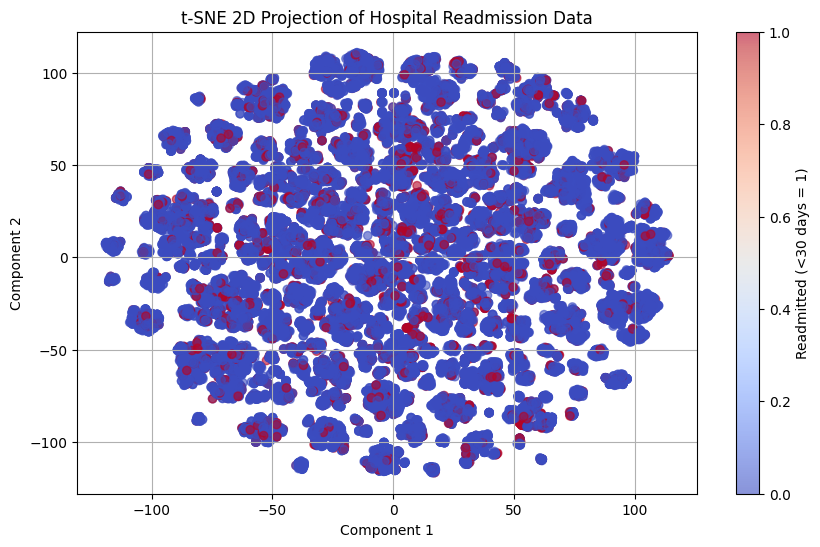

In [13]:
'''
    decided to use tsne because it allows us to turn this multi dimensional space into a 2d space
    therefore, we can see what model is the best to use, as a guess  
    then we can compare THIS inital guess to the FINAL guess
'''
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_embedded = tsne.fit_transform(X_train_scaled.toarray())

# Plot
plt.figure(figsize=(10, 6))
# 0 (NOT readmitted) = blue || 1 (readmitted) = red
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_train, cmap="coolwarm", alpha=0.6)
plt.title()
plt.xlabel("x vals")
plt.ylabel("y vals")
plt.colorbar(scatter, label="Readmitted (<30 days = 1)")
plt.grid(True)
plt.show()

k-Nearest Neighors

In [4]:
knn = KNeighborsClassifier(n_neighbors=5)

# Convert sparse matrices to dense arrays
X_train_dense = X_train_scaled.toarray()
X_test_dense = X_test_scaled.toarray()

knn.fit(X_train_dense, y_train)
y_pred_knn = knn.predict(X_test_dense)

metrics["kNN"] = {
    "Accuracy": accuracy_score(y_test, y_pred_knn),
    "Precision": precision_score(y_test, y_pred_knn),
    "Recall": recall_score(y_test, y_pred_knn),
    "F1": f1_score(y_test, y_pred_knn),
    "AUC": roc_auc_score(y_test, y_pred_knn)
}

for metric_name, value in metrics["kNN"].items():
    print(f"{metric_name}: {value:.4f}")

Accuracy: 0.8823
Precision: 0.2767
Recall: 0.0518
F1: 0.0873
AUC: 0.5177


Logistic Regression

In [5]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

metrics["Logistic Regression"] = {
    "Accuracy": accuracy_score(y_test, y_pred_lr),
    "Precision": precision_score(y_test, y_pred_lr),
    "Recall": recall_score(y_test, y_pred_lr),
    "F1": f1_score(y_test, y_pred_lr),
    "AUC": roc_auc_score(y_test, y_pred_knn)
}

for metric_name, value in metrics["Logistic Regression"].items():
    print(f"{metric_name}: {value:.4f}")

Accuracy: 0.8909
Precision: 0.4494
Recall: 0.0205
F1: 0.0393
AUC: 0.5177


Feedforward Neural Network

In [6]:
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
mlp.fit(X_train_scaled, y_train)
y_pred_mlp = mlp.predict(X_test_scaled)

metrics["Feedforward NN"] = {
    "Accuracy": accuracy_score(y_test, y_pred_mlp),
    "Precision": precision_score(y_test, y_pred_mlp),
    "Recall": recall_score(y_test, y_pred_mlp),
    "F1": f1_score(y_test, y_pred_mlp),
    "AUC": roc_auc_score(y_test, y_pred_knn)
}
for metric_name, value in metrics["Feedforward NN"].items():
    print(f"{metric_name}: {value:.4f}")

Accuracy: 0.8701
Precision: 0.2135
Recall: 0.0729
F1: 0.1087
AUC: 0.5177


Decision Tree

In [7]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_scaled, y_train)
y_pred_dt = dt.predict(X_test_scaled)

metrics["Decision Tree"] = {
    "Accuracy": accuracy_score(y_test, y_pred_dt),
    "Precision": precision_score(y_test, y_pred_dt),
    "Recall": recall_score(y_test, y_pred_dt),
    "F1": f1_score(y_test, y_pred_dt),
    "AUC": roc_auc_score(y_test, y_pred_knn)
}
for metric_name, value in metrics["Decision Tree"].items():
    print(f"{metric_name}: {value:.4f}")

Accuracy: 0.8023
Precision: 0.1559
Recall: 0.1858
F1: 0.1696
AUC: 0.5177


Confusion Matrices

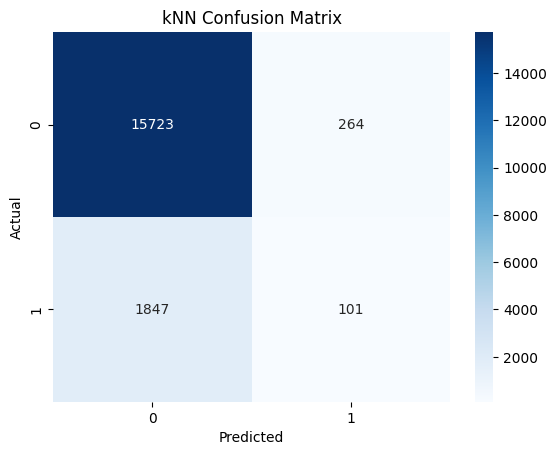

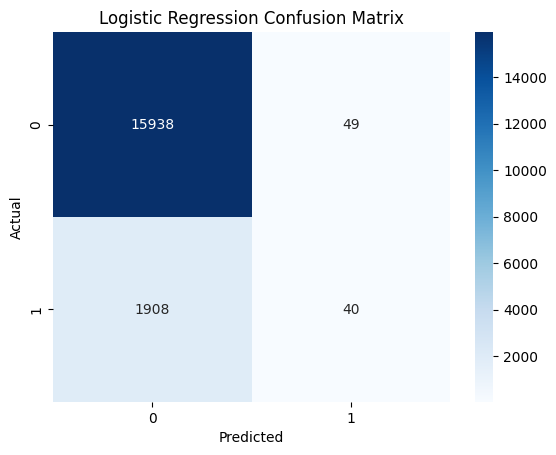

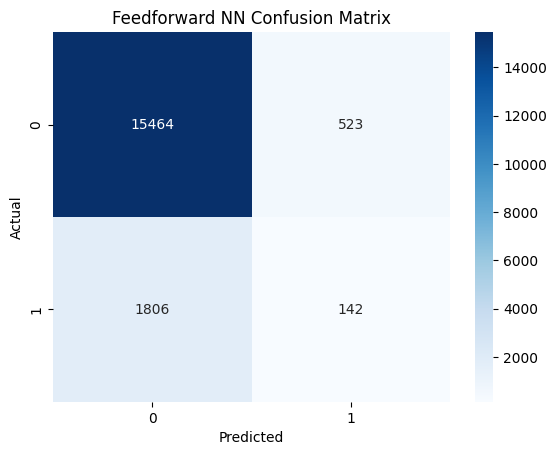

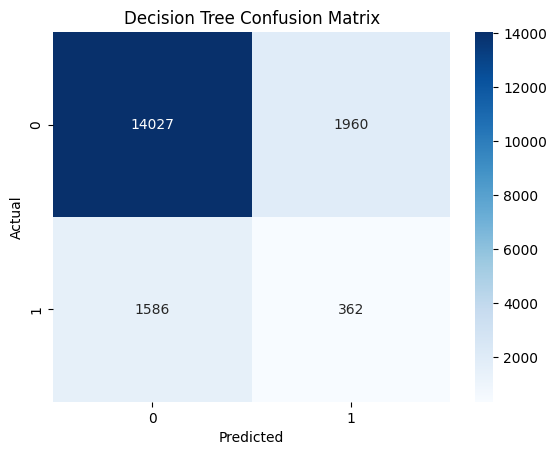

In [8]:
def plot_confusion(title, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

plot_confusion("kNN Confusion Matrix", y_test, y_pred_knn)
plot_confusion("Logistic Regression Confusion Matrix", y_test, y_pred_lr)
plot_confusion("Feedforward NN Confusion Matrix", y_test, y_pred_mlp)
plot_confusion("Decision Tree Confusion Matrix", y_test, y_pred_dt)

Visualization of Metrics

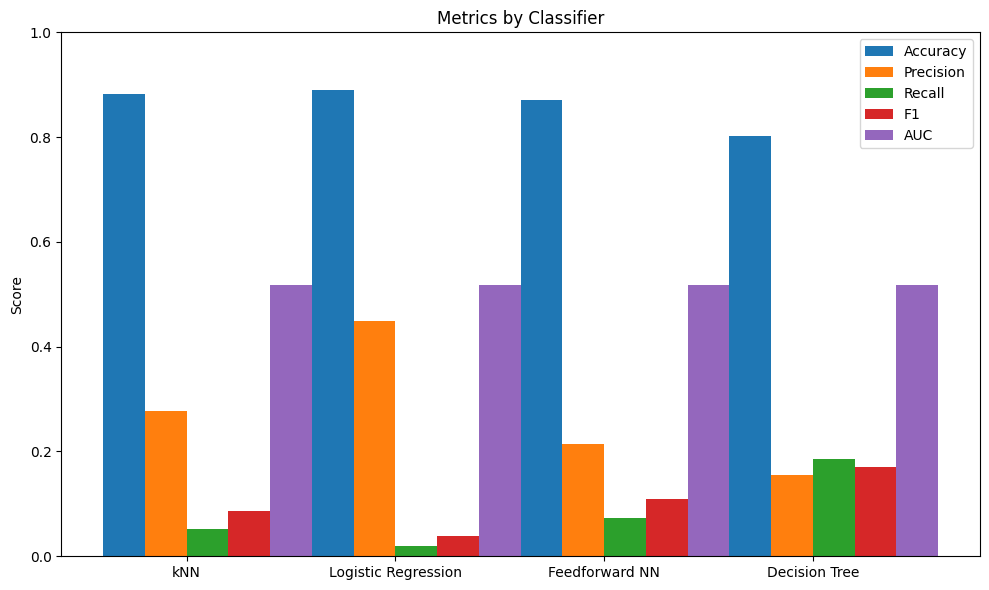

In [9]:
def plot_metrics(metrics_dict):
    metrics_names = ["Accuracy", "Precision", "Recall", "F1", "AUC"]
    classifiers = list(metrics_dict.keys())
    values = {metric: [metrics_dict[classifier][metric] for classifier in classifiers] for metric in metrics_names}

    x = np.arange(len(classifiers))
    width = 0.2

    plt.figure(figsize=(10,6))
    for i, metric in enumerate(metrics_names):
        plt.bar(x + i*width, values[metric], width=width, label=metric)

    plt.xticks(x + width*1.5, classifiers)
    plt.ylabel("Score")
    plt.title("Metrics by Classifier")
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_metrics(metrics)